In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
import re as re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



from sklearn.multiclass import  OneVsRestClassifier

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
import gc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')


In [2]:
def reduce_mem(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [121]:
# Loading all "csv" files.
# I named the dataframe as per the orginal name associated with "CSV" files.
framenames =[]
varsname =[]
for file in os.listdir("DataSet"):    
    if file.endswith(".csv"):
        filepath = os.path.join("DataSet", file)
        name = [i.split(".") for i in file.split("_")]
        name = reduce(lambda x, y: x + y ,name)[:-1]
        name = "_".join(name)
        vars()[name] = pd.read_csv(filepath, encoding = 'unicode_escape')
        print(name)
        framenames.append(name)
        varsname.append(vars()[name])

application_test
HomeCredit_columns_description
POS_CASH_balance
credit_card_balance
installments_payments
application_train
bureau
previous_application
bureau_balance
sample_submission


In [122]:
# applying the reduce_mem function
test = reduce_mem(application_test)
HomeCredit_columns_description = reduce_mem(HomeCredit_columns_description )
POS_CASH_balance = reduce_mem(POS_CASH_balance)
credit_card_balance = reduce_mem(credit_card_balance)
installments_payments = reduce_mem(installments_payments)
train = reduce_mem(application_train)
bureau= reduce_mem(bureau)
previous_application = reduce_mem(previous_application )
bureau_balance = reduce_mem(bureau_balance)

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 14.9%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


In [123]:
# deleting the unused file from the memory
del application_test, application_train


In [12]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [15]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [64]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [68]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
class aggregator(object):
    
    def __int__(self):
        pass
    
    def numeric_aggregation(self, df, df_name,
                            groupby_variable ="SK_ID_CURR", 
                            aggregation_functions = ["mean", "max", "min", "sum", "std","count" ]):
        """
        Parameters:
        -----------
        df (DataFrame): the dataframe to perform numeric aggregation on.
        df_name: Name of the the dataframe which will be used to name the engineered features.
        groupby_variable: the variable that will be used to aggregate.
        aggregation_functions: the functions that will be used for aggregations.
        
        """
        
        # Removing id variables other than grouping variable
        for column in df:
            if column != groupby_variable and "SK_ID" in column:
                df = df.drop(columns = column, axis =1)
                
        ids = df[groupby_variable]
        numeric_df = df.select_dtypes("number")
        numeric_df[groupby_variable] =ids
        
        # Grouping by groupby_variable and aggregating using the list of functions in aggregation_functions
        aggregated_df = numeric_df.groupby(groupby_variable).agg(aggregation_functions).reset_index()
        
        
        column_names =[groupby_variable]
        # Rename the column names after the dataframe
        
        for column_name in aggregated_df.columns.levels[0]:
            if column_name != groupby_variable:
                for estimator in aggregated_df.columns.levels[1][:-1]:
                    column_names.append("%s_%s_%s" % (df_name , column_name, estimator))
                    
        aggregated_df.columns = column_names
        return aggregated_df
    
    def categorical_aggregation(self,df, df_name,
                            groupby_variable ="SK_ID_CURR", 
                            aggregation_functions = ["mean", "sum"] ):
        # Creating dummies for object columns
        categorical_dummies = pd.get_dummies(df.select_dtypes("object"))
        # transferring group_by variable
        categorical_dummies[groupby_variable ] = df[groupby_variable ]
        # Grouping by
        categorical_dummies_grouped = categorical_dummies.groupby(groupby_variable ).agg(aggregation_functions )
        
        # Rename the column names after the dataframe
        
        column_names =[]
        
        for column_name in categorical_dummies_grouped.columns.levels[0]:
            #if column_name != groupby_variable:
            for estimator in categorical_dummies_grouped.columns.levels[1]:
                column_names.append("%s_%s_%s" % (df_name , column_name, estimator))
                    
        categorical_dummies_grouped.columns = column_names
        return categorical_dummies_grouped
    
    def target_correlation(self, df, target_column ="TARGET"):
        """
        df = dataframe
        target_column = name of column to find correlation with
        """
        # List of correlations
        correlations =[]
        for column in df.columns:
            # Skipping the target columns
            if column != target_column:
                correlation = df[target_column].corr(df[column])
                correlations.append((column, correlation))
        # Sorting by absolute magnitude of correlations
        correlations = sorted(correlations, key = lambda x: abs(x[1]), reverse = True)
        
        return correlations
        
    
    def missing_values(self, df, figsize=(10, 30)):
        plt.style.use('fivethirtyeight')
        misval= df.isnull().sum()
        df_misval = pd.DataFrame(misval[misval!=0])
        df_misval.columns = ['frequency']
        df_misval["percentage"] = (df_misval/len(df))*100
        df_misval =df_misval.sort_values("percentage", ascending = False)[:100]

        # If there are more than 50 % values are missing, it will appear as red. 
        colors = ['red' if (x > 50.00) else 'green' for x in df_misval['percentage']]
        # Now Plotting missing values as well as the dataframe
        f, ax = plt.subplots(1,2, figsize=figsize)

        b= sns.barplot(x= "percentage", y = df_misval.index,
                    data = df_misval, palette=colors, label = "biggest")
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 30}
        b.set_xlim(0,100)
        b.set_xlabel("Percentage (%)", fontdict = font)
        b.set_title("Percentage of Missing Values", fontsize = 30)

        # Annotaing the acutal number
        for index, row in df_misval.reset_index().iterrows():
            b.text(10+row.percentage,row.name, str(round(row.percentage,1)) + " %", color='black', va="center")
        #ax.tick_params(axis = 'x', which = 'both', labelsize = 16)

        plt.rc("font")
        plt.tight_layout()
        
    def lgboost_model(self, train, test,
                      encoder = "ohe", n_folds_cv =3,
                      id_column_name = "SK_ID_CURR",
                      target_column_name ="TARGET"):
        
        """
        Train and test a light gradient boosting model using KFold cross validation.
        
        train: a dataframe of training smaples containing features and the target column.
        test: a dataframe of testing sample containing features.
        
        """

        
        #Extracting the ID columns
        train_id = train[id_column_name]
        test_id = test[id_column_name]


        # Extracting the target columns
        target = train[target_column_name]


        
        # Encoding train and test data
        train = self.encoder(train, encoder =encoder)
        test = self.encoder(test, encoder = encoder)
        print("{} encoded\n".format(encoder))
        
        # Aligning the train and test data
        train, test = self.align_train_test(train, test, target_column_name =target_column_name)
        
        #Droping the id and target columns
        train = train.drop([target_column_name,id_column_name], axis=1)
        test = test.drop(id_column_name,axis =1)
        
        if train.shape[1] == test.shape[1]:
            
            print("\nShape of the train and the test data {} after droping the id and target columns".format(train.shape))
        else:
            raise ValueError("Check the train and test data")
            
        # Extracting the categorical features
        categorical_features = self.find_categorical_fetures(train)
        
        # Extracting all feature names
        feature_names = train.columns.tolist()
        
        # converting into arrays
        train = train.values
        test = test.values
        
        
        # Instantiating kfold cross validation
        kfold = KFold(n_splits = n_folds_cv,
                                shuffle =True, random_state =42)
        
        # Creating an empty array for the feature importance values,
        #which will be extracted after training the model
        n_fold_feature_importance = np.zeros((len(feature_names),n_folds_cv))
        
        # Creating an empty array for the test prediction values for all folds.
        # The final prediction will be the average of all predicted values. 
        
        n_fold_test_predictions = np.zeros((test.shape[0],n_folds_cv))
        
        # # Creating an empty array for the validation prediction values for all folds.
        # This will be one dimensional  and equal to the shape of train.shape[0]
        validation_predictions = np.zeros(train.shape[0])
        
        # Recording validating and train scores for each fold validation
        train_scores =[]
        validation_scores =[]
        
        # Iterating over all cross validation sets
        for each_validation, (train_indices, validation_indices) in zip(range(n_folds_cv), kfold.split(train)):
            
            X_train, y_train = train[train_indices], target[train_indices]
            
            X_validation, y_validation = train[validation_indices], target[validation_indices]
            
            model =  lgb.LGBMClassifier(n_esitmators =10000,
                                      objective ="binary",
                                      class_weight = "balanced",
                                      learning_rate = 0.05,
                                      reg_alpha =0.1,
                                      reg_lambda =0.1,
                                        subsample = 0.8,
                                       n_jobs = -1,
                                       num_boost_round =1000)
            
            print("\nFitting the model")
            
            model.fit(X_train, y_train,
                     eval_metric ="auc",
                     eval_set =[(X_train, y_train), (X_validation, y_validation)],
                     eval_names = ["train", "validation"],
                     categorical_feature = categorical_features,
                     early_stopping_rounds =100, verbose =100)
            
            # Recording the best iteration
            best_iteration = model.best_iteration_
            #n_fold_validation_predictions = np.zeros(train.shape[0])
            
            print("\nPredicting the validation and test data")
            
            # Recording the feature importances, and test predictions
            n_fold_feature_importance[:,each_validation] = model.feature_importances_

            n_fold_test_predictions[:,each_validation] = model.predict_proba(
                test, num_iteration = best_iteration)[:,1]
            
            # Recording the validation predictions by the validation_indices
            validation_predictions[validation_indices] = model.predict_proba(
                X_validation, num_iteration = best_iteration)[:,1]
            
            # Recording the best score
            train_scores.append(model.best_score_["train"]["auc"])
            validation_scores.append(model.best_score_["validation"]["auc"])
            
            # Cleaning up the memory
            print("\nCleaning up the memory")
            gc.enable()
            del model, X_train, X_validation
            gc.collect()
            
        print("\nCreating data frames for metrics")
        # Averaging all predictions 
        test_predictions =n_fold_test_predictions.mean(axis =1)

        feature_importance = n_fold_feature_importance.mean(axis =1)
        
        # Making the submission dataframe
        submission = pd.DataFrame({id_column_name: test_id, 'TARGET': test_predictions})
        
        
        # Make the feature importance dataframe
        feature_importances = pd.DataFrame({'feature_names': feature_names, 'importance': feature_importance})
        
        # Overall validation score
        validation_auc = roc_auc_score(target, validation_predictions)
        
        # Adding the overall scores to the metrics
        validation_scores.append(validation_auc)
        train_scores.append(np.mean(train_scores))
        
        # Needed for creating dataframe of validation scores
        number_folds = list(range(n_folds_cv))
        number_folds.append('overall')

        # Dataframe of validation scores
        performance_table = pd.DataFrame({'number_fold': number_folds,
                                'train_scores': train_scores,
                                'validation_scores': validation_scores}) 
        
        return submission, feature_importances, performance_table
    
        
    def plot_feature_importance(self, df):
        
        plt.style.use('fivethirtyeight')
        # Normalize the feature impotances
        df['importance'] = df['importance'] / df['importance'].sum()


        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=(6, 15))

        sns.barplot(x="importance", y="feature_names",
                    data=df.sort_values("importance", ascending=False)[:50],
                    label="Most Important Features", color="r")


        # Plot labeling
        plt.xlabel('Normalized Importance');
        plt.ylabel('Features');
        
        plt.title('Most Important Features')
        plt.show()
        
    def featurs_engineering_domain_knowledge(self, train, test):
        
        """ Feature Engineering based on the domain knowledge. (Acknowledgement : Aguiar - Kaggle)
        This function is geared to Kaggle Compitition project-HomeDefaultCredit
        """
        
        train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
        train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
        train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
        train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
        
        test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
        test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
        test['CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
        test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
        
        return train, test
    
    def align_train_test(self, train, test, target_column_name ="TARGET"):
        
        """ 
        
        Parameters:
        ----------
            train: a dataframe of training smaples containing features and the target column.
            test: a dataframe of testing sample containing features.
            target_column ="TARGET"(default), but specify the target_column if different.
        
        """
        

        print(" Shape of train data before alinging: {}".format(train.shape),"\n", 
             "Shape of test data before alinging: {}".format(test.shape))
        
        target_column = train[target_column_name]
        train, test = train.align(test, join="inner", axis =1)
        train[target_column_name] = target_column
        print(" Shape of train data after alinging: {}".format(train.shape), "\n", 
         "Shape of test data after alinging: {}".format(test.shape))
        
        return train, test
    
    def colinear_variables(self, df,threshold = 0.9):
        # Codes for removing colinear variables
        corr = round(df.drop(["TARGET","SK_ID_CURR"], axis =1).sample(10000).corr(),3)

        cols = list(corr.columns)
        index = list(corr.index)
        idx_col ={}
        for idx in index:
            for col in cols:
                idx_col[idx,col] = corr.loc[idx,col]

        # Removing self correlated entries        
        idx_col = {key:idx_col[key] for key in idx_col if key[0]!=key[1]}

        # Listing colinear variables
        colinear_variables =[]
        threshold = 0.9
        for key, value in idx_col.items():
            if value > threshold:
                colinear_variables.append(key[1])
        colinear_variables  = list(set(colinear_variables))
        
            
        del cols, index, idx_col, corr
        
        return colinear_variables

        
    def remove_colinear_variables(self, train, test, colinear_variables):
        # Romoving colinear variables
        train= train.drop(labels = colinear_variables, axis =1)
        test= test.drop(labels = colinear_variables, axis =1)
        
        train, test = self.align_train_test(train, test, target_column_name ="TARGET")
        
        return train, test
    
    def plot_feature_importance(self, df):
        
        plt.style.use('fivethirtyeight')
        # Normalize the feature impotances
        df['importance'] = df['importance'] / df['importance'].sum()


        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=(6, 15))

        sns.barplot(x="importance", y="feature_names",
                    data=df.sort_values("importance", ascending=False)[:50],
                    label="Most Important Features", color="r")


        # Plot labeling
        plt.xlabel('Normalized Importance');
        plt.ylabel('Features');
        
        plt.title('Most Important Features')
        plt.show()
        
        
    def features_engineering(self, features,
                             df_train, df_test,
                             id_column_name = "SK_ID_CURR",
                             target_column_name ="TARGET",
                             degree =3 ):
        """ Features are given as a list."""
        df_train_eng = df_train[features]
        df_test_eng = df_test[features]

        # Imputations
        imputer = Imputer(strategy='mean')
        # Instantiating polynomialfeaures
        pf = PolynomialFeatures(degree, include_bias =False)

        df_train_eng =imputer.fit_transform(df_train_eng)
        df_train_eng =pf.fit_transform(df_train_eng)

        df_test_eng =imputer.transform(df_test_eng)
        df_test_eng =pf.transform(df_test_eng)
        print("Shape of the Engineered Treaining Data: {}".format(df_train_eng.shape))
        print("Shape of the Engineered Test Data: {}".format(df_test_eng.shape))
        print("First 15 Engineered Features: {}".format(pf.get_feature_names(input_features = features)[:15]))

        # Converting the engineered features into a data frame
        df_train_eng = pd.DataFrame(df_train_eng, columns=pf.get_feature_names(input_features = features))
        df_test_eng = pd.DataFrame(df_test_eng, columns=pf.get_feature_names(input_features = features))


        # Now merging the engineered dataframes
        df_train_eng[id_column_name] =df_train[id_column_name]
        df_test_eng[id_column_name] =df_test[id_column_name]


        df_train = df_train.merge(df_train_eng, how= "left", on = id_column_name)
        df_test = df_test.merge(df_test_eng, how= "left", on = id_column_name)

        # Aligning the engineered train and test data
        if df_train.shape != df_test.shape:
            df_train, df_test = self.align_train_test(df_train, df_test)

        # Adding the "TARGET" features to the engineered dataframe 
        df_train_eng[target_column_name] =df_train[target_column_name]

        return df_train_eng, df_test_eng, df_train, df_test
    
    def find_categorical_fetures(self, df):
        """
        This function takes a dataframe and return a list of catergorical columns.

        """
    
        categorical_features_list = df.columns[df.dtypes=="object"].tolist()
    
        return categorical_features_list
    
    def encoder(self,df, encoder ="ohe"):
        """
        encoder: str, default ="ohe", {"ohe": OneHotEncoding, "le":LabelEncoding}
        scaler: str, default ="MinMaxScaler",{"MinMaxScaler","StandardScaler" }
        n_folds: number of folds for cross validation. 
    
        """
    
        indices_for_columns_label_encoded =[]
        
        if encoder=="ohe":
            df = pd.get_dummies(df)

        elif encoder =="le":
            le = LabelEncoder()
            categorical_features = self.find_categorical_fetures(df)
            df[categorical_features] = df[categorical_features].astype(str).apply(
                lambda x: le.fit_transform(x)
            )
            

        else:
            raise ValueError("The encoder has to be either 'ohe' or 'le' ")
            
        return df
    
    def top10correlated_features(self, df_train):
        
        top10correlated_features= df_train.drop("SK_ID_CURR",
                                                axis =1 ).sample(10000).corr().sort_values(
            "TARGET", ascending =False)[["TARGET"]].dropna().tail(10).index.tolist()
        return top10correlated_features
    
        
agg = aggregator()       

['bureau_CREDIT_TYPE_Consumer credit_mean',
 'balance_bureau_balance_MONTHS_BALANCE_sum_std',
 'balance_bureau_balance_STATUS_C_mean_mean',
 'balance_bureau_balance_STATUS_C_mean_max',
 'balance_bureau_balance_STATUS_C_sum_mean',
 'bureau_DAYS_CREDIT_UPDATE_std',
 'bureau_CREDIT_ACTIVE_Closed_mean',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1']

In [124]:
## Aggregating numeric and categorical columns of bureau_balance dataframe
bureau_balance_num_aggregated = agg.numeric_aggregation(bureau_balance,
                                                    "bureau_balance",
                                               groupby_variable='SK_ID_BUREAU')
bureau_balance_cat_aggregated = agg.categorical_aggregation(bureau_balance, "bureau_balance",
                                                           groupby_variable='SK_ID_BUREAU')

# Merging the aggregated (categorical and numeric ) bureau_balance dataframe

bureau_balance_agg = pd.merge(bureau_balance_num_aggregated,
                               bureau_balance_cat_aggregated,
                              on ="SK_ID_BUREAU", how ="outer")

# Merging to include SK_ID_CURR
bureau_balance_agg = bureau[["SK_ID_CURR", "SK_ID_BUREAU"]].merge(bureau_balance_agg,
                                                          on= "SK_ID_BUREAU",
                                                         how  ="left")
# Now performing again numeric aggregation
bureau_balance_agg = agg.numeric_aggregation(bureau_balance_agg, "balance", groupby_variable='SK_ID_CURR' )

bureau_balance_agg.head()

,SK_ID_CURR,balance_bureau_balance_MONTHS_BALANCE_mean_mean,balance_bureau_balance_MONTHS_BALANCE_mean_max,balance_bureau_balance_MONTHS_BALANCE_mean_min,balance_bureau_balance_MONTHS_BALANCE_mean_sum,balance_bureau_balance_MONTHS_BALANCE_mean_std,balance_bureau_balance_MONTHS_BALANCE_mean_count,balance_bureau_balance_MONTHS_BALANCE_max_mean,balance_bureau_balance_MONTHS_BALANCE_max_max,balance_bureau_balance_MONTHS_BALANCE_max_min,...,balance_bureau_balance_STATUS_X_mean_min,balance_bureau_balance_STATUS_X_mean_sum,balance_bureau_balance_STATUS_X_mean_std,balance_bureau_balance_STATUS_X_mean_count,balance_bureau_balance_STATUS_X_sum_mean,balance_bureau_balance_STATUS_X_sum_max,balance_bureau_balance_STATUS_X_sum_min,balance_bureau_balance_STATUS_X_sum_sum,balance_bureau_balance_STATUS_X_sum_std,balance_bureau_balance_STATUS_X_sum_count
0,100001,-11.785714,-0.5,-25.5,-82.5,8.025258,7,0.0,0.0,0.0,...,0.0,1.502129,0.182611,7,4.285714,9.0,0.0,30.0,3.817254,7
1,100002,-21.875000,-1.5,-39.5,-175.0,12.176529,8,-15.5,0.0,-32.0,...,0.0,1.295455,0.161650,8,1.875000,3.0,0.0,15.0,1.356203,8
2,100003,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,NaN,...,NaN,0.000000,NaN,0,NaN,NaN,NaN,0.0,NaN,0
3,100004,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,NaN,...,NaN,0.000000,NaN,0,NaN,NaN,NaN,0.0,NaN,0
4,100005,-3.000000,-1.0,-6.0,-9.0,2.645751,3,0.0,0.0,0.0,...,0.0,0.410256,0.174535,3,0.666667,1.0,0.0,2.0,0.577350,3


In [125]:
## Aggregating numeric and categorical columns of bureau dataframe
bureau_num_aggregated = agg.numeric_aggregation(bureau, "bureau", groupby_variable='SK_ID_CURR')
bureau_cat_aggregated = agg.categorical_aggregation(bureau, "bureau", groupby_variable='SK_ID_CURR')

# Merging the aggregated (categorical and numeric ) bureau dataframe
bureau_agg = pd.merge(bureau_num_aggregated,
                               bureau_cat_aggregated,
                              on ="SK_ID_CURR", how ="outer")
bureau_agg.head()



,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_std,bureau_DAYS_CREDIT_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Mortgage_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_sum
0,100001,-735.000000,-49,-1572,-5145.0,489.942514,7,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1,100002,-874.000000,-103,-1437,-6992.0,431.451040,8,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2,100003,-1400.750000,-606,-2586,-5603.0,909.826128,4,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
3,100004,-867.000000,-408,-1326,-1734.0,649.124025,2,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
4,100005,-190.666667,-62,-373,-572.0,162.297053,3,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [99]:
# Merging bureau_agg and bureau_balance_agg
bureau_balanced_merged = pd.merge(bureau_agg, bureau_balance_agg, on ="SK_ID_CURR", how = "left")

In [100]:
bureau_balanced_merged.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_std,bureau_DAYS_CREDIT_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_X_mean,bureau_balance_STATUS_X_sum
0,100001,-735.0,-49,-1572,-5145.0,489.942514,7,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.655172,19.0,0.241379,7.0
1,100001,-735.0,-49,-1572,-5145.0,489.942514,7,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.966667,29.0,0.000000,0.0
2,100001,-735.0,-49,-1572,-5145.0,489.942514,7,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.620690,18.0,0.310345,9.0
3,100001,-735.0,-49,-1572,-5145.0,489.942514,7,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.846154,44.0,0.134615,7.0
4,100001,-735.0,-49,-1572,-5145.0,489.942514,7,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.315789,6.0


In [126]:
bureau_balanced_merged.info()

NameError: name 'bureau_balanced_merged' is not defined

In [ ]:
# Integrating bureau_balanced_merged with the training and test  data
train_merged = pd.merge(train, bureau_balanced_merged, on ="SK_ID_CURR", how ="left")

In [ ]:
train_merged.info()

In [98]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_std,bureau_DAYS_CREDIT_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Mortgage_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_sum
0,100001,-735.000000,-49,-1572,-5145.0,489.942514,7,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1,100002,-874.000000,-103,-1437,-6992.0,431.451040,8,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2,100003,-1400.750000,-606,-2586,-5603.0,909.826128,4,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
3,100004,-867.000000,-408,-1326,-1734.0,649.124025,2,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
4,100005,-190.666667,-62,-373,-572.0,162.297053,3,0.0,0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [55]:
bureau_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 0 to 305810
Columns: 119 entries, SK_ID_CURR to bureau_CREDIT_TYPE_Unknown type of loan_sum
dtypes: float16(10), float32(30), float64(32), int16(5), int32(3), int64(13), int8(3), uint8(23)
memory usage: 162.2 MB


In [32]:
len(train.columns), len(bureau_agg.columns), len(bureau_balance_agg.columns)

(122, 119, 24)

In [128]:
# Creating a list for all dataframes to be mereged
frames_train = [train,  bureau_agg, bureau_balance_agg]
frames_test = [test,  bureau_agg, bureau_balance_agg]

In [129]:
# Inserting the computed and manupulated dataframes into train and test data
df_train = reduce(lambda  left,right: pd.merge(left,right,on="SK_ID_CURR",
                                               how='left'), frames_train)
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,balance_bureau_balance_STATUS_X_mean_min,balance_bureau_balance_STATUS_X_mean_sum,balance_bureau_balance_STATUS_X_mean_std,balance_bureau_balance_STATUS_X_mean_count,balance_bureau_balance_STATUS_X_sum_mean,balance_bureau_balance_STATUS_X_sum_max,balance_bureau_balance_STATUS_X_sum_min,balance_bureau_balance_STATUS_X_sum_sum,balance_bureau_balance_STATUS_X_sum_std,balance_bureau_balance_STATUS_X_sum_count
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,1.295455,0.16165,8.0,1.875,3.0,0.0,15.0,1.356203,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0


In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 372 entries, SK_ID_CURR to balance_bureau_balance_STATUS_X_sum_count
dtypes: float16(71), float32(34), float64(210), int16(2), int32(2), int8(37), object(16)
memory usage: 628.5+ MB


In [131]:
df_test = reduce(lambda  left,right: pd.merge(left,right,on=["SK_ID_CURR"],
                                               how='left'), frames_test)
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,balance_bureau_balance_STATUS_X_mean_min,balance_bureau_balance_STATUS_X_mean_sum,balance_bureau_balance_STATUS_X_mean_std,balance_bureau_balance_STATUS_X_mean_count,balance_bureau_balance_STATUS_X_sum_mean,balance_bureau_balance_STATUS_X_sum_max,balance_bureau_balance_STATUS_X_sum_min,balance_bureau_balance_STATUS_X_sum_sum,balance_bureau_balance_STATUS_X_sum_std,balance_bureau_balance_STATUS_X_sum_count
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0.0,1.502129,0.182611,7.0,4.285714,9.0,0.0,30.0,3.817254,7.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.410256,0.174535,3.0,0.666667,1.0,0.0,2.0,0.577350,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0.0,1.018182,0.497044,4.0,10.250000,40.0,0.0,41.0,19.838935,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,3.125213,0.397186,12.0,11.083333,60.0,0.0,133.0,19.435012,12.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
# Freeing up memory by deleting old objects
import gc
gc.enable()
del bureau_cat_aggregated, 
bureau_balance_cat_aggregated, 
bureau_balance_agg,
bureau_agg,
bureau,
bureau_balance,
train,
test,

gc.collect()

730

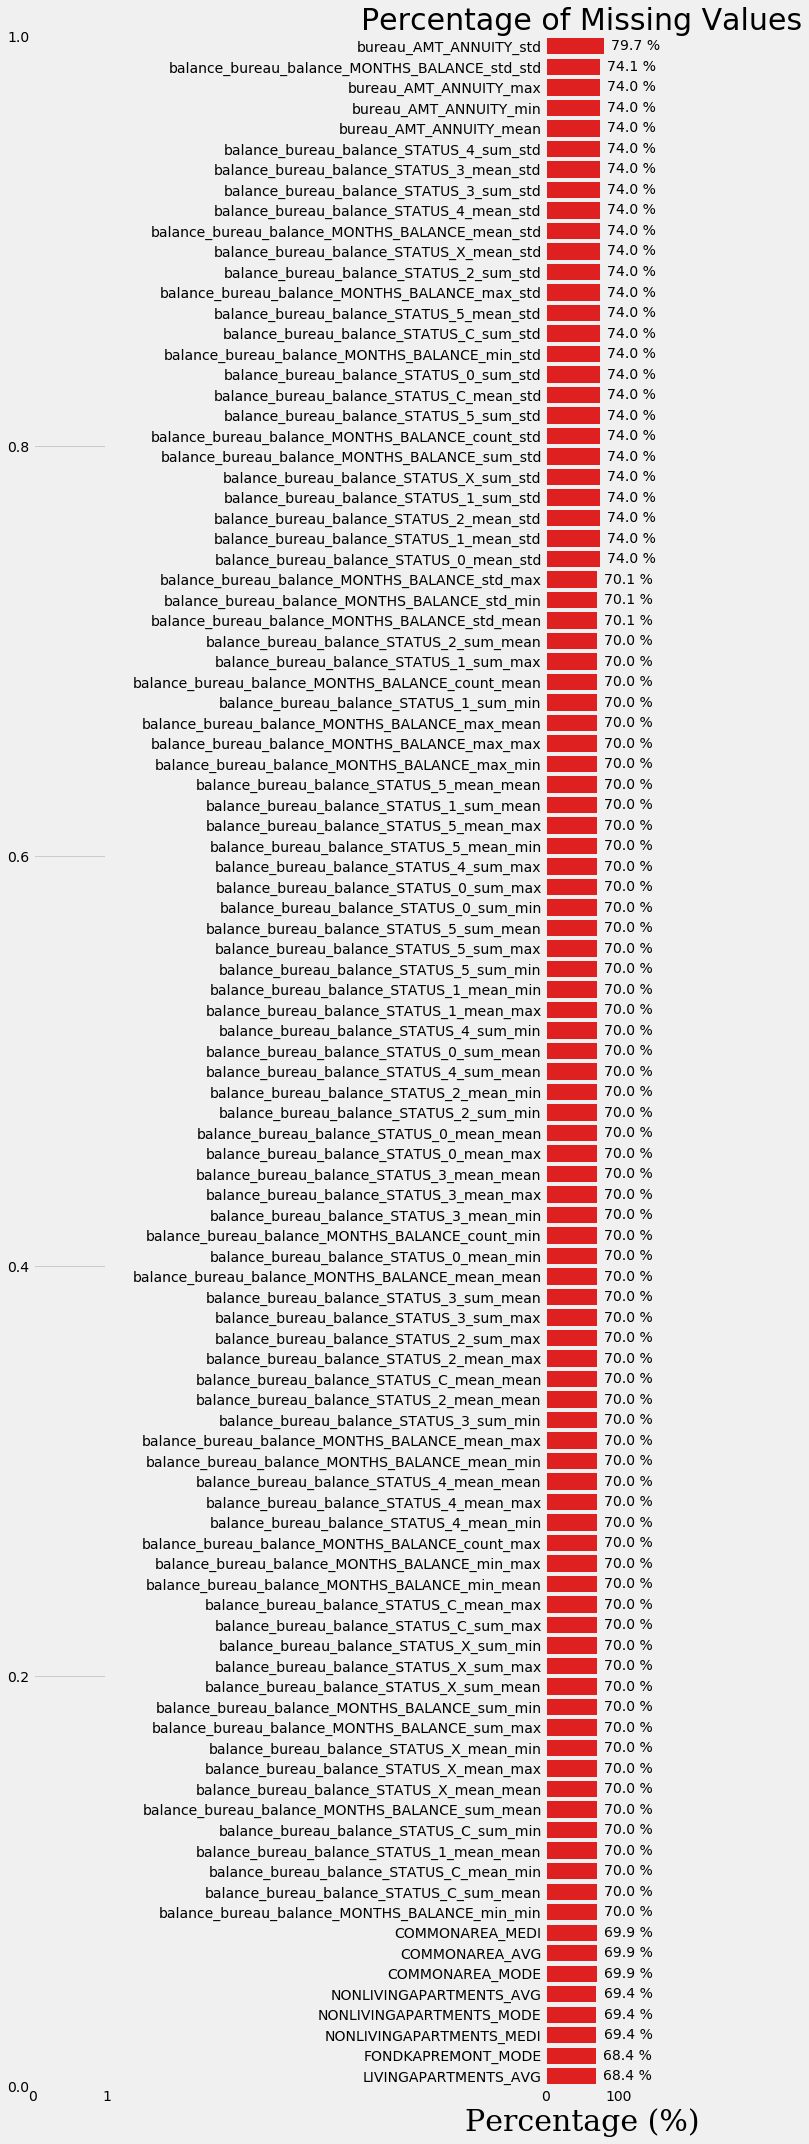

In [120]:
agg.missing_values(df_train,)

In [121]:
# Saving the integrated dataframes
df_train.to_csv("train_bureau_balance.csv", index = False)
df_test.to_csv("test_bureau_balance.csv", index = False)

In [145]:
df_train = reduce_mem(pd.read_csv("train_bureau_balance.csv"))
df_test = reduce_mem(pd.read_csv("test_bureau_balance.csv"))

Memory usage of dataframe is 872.76 MB
Memory usage after optimization is: 265.41 MB
Decreased by 69.6%
Memory usage of dataframe is 137.97 MB
Memory usage after optimization is: 41.56 MB
Decreased by 69.9%


In [4]:
#finding correlations
correlation = df_train.drop(columns =["SK_ID_CURR"],axis =1).sample(10000).corr()
correlation =correlation.sort_values("TARGET", ascending =False)
correlatoin_target = pd.DataFrame(correlation["TARGET"])
correlatoin_target.head(15)

,TARGET
TARGET,1.000000
balance_bureau_balance_MONTHS_BALANCE_min_min,0.105296
balance_bureau_balance_MONTHS_BALANCE_min_mean,0.100239
DAYS_BIRTH,0.092397
balance_bureau_balance_STATUS_1_mean_mean,0.089650
bureau_DAYS_CREDIT_mean,0.089442
balance_bureau_balance_STATUS_1_mean_std,0.089088
balance_bureau_balance_MONTHS_BALANCE_mean_mean,0.088284
balance_bureau_balance_STATUS_1_mean_max,0.087162
bureau_DAYS_CREDIT_min,0.080240


In [123]:
correlatoin.dropna().tail(30)

,TARGET
bureau_CREDIT_TYPE_Consumer credit_mean,-0.039326
balance_bureau_balance_STATUS_0_sum_std,-0.044470
DAYS_EMPLOYED,-0.044891
balance_bureau_balance_STATUS_0_sum_max,-0.047050
balance_bureau_balance_STATUS_C_sum_min,-0.055460
balance_bureau_balance_MONTHS_BALANCE_mean_std,-0.058425
balance_bureau_balance_STATUS_0_sum_mean,-0.060036
balance_bureau_balance_MONTHS_BALANCE_std_std,-0.062829
balance_bureau_balance_STATUS_C_mean_max,-0.063974
balance_bureau_balance_MONTHS_BALANCE_count_std,-0.064336


In [36]:
correlation.drop("TARGET", axis =1).head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,balance_bureau_balance_STATUS_X_mean_min,balance_bureau_balance_STATUS_X_mean_sum,balance_bureau_balance_STATUS_X_mean_std,balance_bureau_balance_STATUS_X_mean_count,balance_bureau_balance_STATUS_X_sum_mean,balance_bureau_balance_STATUS_X_sum_max,balance_bureau_balance_STATUS_X_sum_min,balance_bureau_balance_STATUS_X_sum_sum,balance_bureau_balance_STATUS_X_sum_std,balance_bureau_balance_STATUS_X_sum_count
TARGET,0.008853,-0.023243,-0.030797,-0.011738,-0.040371,-0.043333,0.092397,-0.052394,0.051094,0.037587,...,0.006776,0.000763,0.001762,0.010900,-0.045754,-0.048769,-0.000872,-0.019150,-0.056645,0.010900
balance_bureau_balance_MONTHS_BALANCE_min_min,0.012870,-0.073141,-0.117731,-0.071195,-0.119876,0.002443,0.238239,-0.054705,0.102007,0.178691,...,0.160450,-0.269616,-0.128645,-0.477169,-0.237731,-0.381216,0.006062,-0.350782,-0.307137,-0.477169
balance_bureau_balance_MONTHS_BALANCE_min_mean,0.004390,-0.026500,-0.115471,-0.079597,-0.114843,-0.008037,0.189351,-0.043118,0.076564,0.143257,...,0.065022,-0.064414,-0.041556,-0.143064,-0.305690,-0.318509,-0.150454,-0.247793,-0.319141,-0.143064
DAYS_BIRTH,0.326365,0.053629,-0.061572,0.002828,-0.061629,-0.028343,1.000000,-0.616363,0.335922,0.270673,...,0.047366,0.003337,0.022084,-0.017920,-0.016054,-0.045568,0.015111,-0.009449,-0.030429,-0.017920
balance_bureau_balance_STATUS_1_mean_mean,0.037812,-0.009974,-0.045831,-0.013905,-0.048448,0.006813,0.050444,-0.047284,-0.001166,0.053358,...,-0.078288,-0.096785,-0.082890,-0.050796,-0.094890,-0.089326,-0.056182,-0.080478,-0.073470,-0.050796


 I need to remove highly colinear variables

In [108]:
# Codes for removing colinear variables
corr = round(df_train.drop(["TARGET","SK_ID_CURR"], axis =1).sample(10000).corr(),3)

cols = list(corr.columns)
index = list(corr.index)
idx_col ={}
for idx in index:
    for col in cols:
        idx_col[idx,col] = corr.loc[idx,col]
        
# Removing self correlated entries        
idx_col = {key:idx_col[key] for key in idx_col if key[0]!=key[1]}

# Listing colinear variables
colinear_variables =[]
threshold = 0.9
for key, value in idx_col.items():
    if value > threshold:
        colinear_variables.append(key[1])
colinear_variables  = list(set(colinear_variables))
del cols, index, idx_col, corr


In [109]:
# Romoving colinear variables
df_train_eng = df_train.drop(columns = colinear_variables, axis =1)

# Again checking correlations
df_train_eng.drop(
    "SK_ID_CURR", axis =1
).sample(10000).corr().sort_values(
    "TARGET", ascending =False
)[["TARGET"]].dropna().tail(10)

,TARGET
bureau_CREDIT_TYPE_Mortgage_sum,-0.036174
REGION_POPULATION_RELATIVE,-0.038457
bureau_AMT_CREDIT_SUM_mean,-0.041100
DAYS_EMPLOYED,-0.042650
balance_bureau_balance_STATUS_C_mean_std,-0.045374
balance_bureau_balance_MONTHS_BALANCE_sum_std,-0.047835
bureau_DAYS_CREDIT_UPDATE_std,-0.051174
balance_bureau_balance_STATUS_C_mean_max,-0.058804
balance_bureau_balance_STATUS_0_sum_mean,-0.059247
balance_bureau_balance_STATUS_C_mean_mean,-0.066822


In [143]:
# Finding colinear_variables
colinear_vairables = agg.colinear_variables(df_train,threshold=0.8)

In [146]:
# Removing colinear_variables
df_train, df_test = agg.remove_colinear_variables(df_train, df_test, colinear_variables)

 Shape of train data before alinging: (307511, 181) 
 Shape of test data before alinging: (48744, 180)
 Shape of train data after alinging: (307511, 181) 
 Shape of test data after alinging: (48744, 180)


In [147]:
# threshold=0.8, for removing colinear variables
# running the model with features engineered from bureau, and bureau_balance
submission, feature_importances, performance_table = agg.lgboost_model(df_train,df_test)

ohe encoded

 Shape of train data before alinging: (307511, 305) 
 Shape of test data before alinging: (48744, 301)
 Shape of train data after alinging: (307511, 302) 
 Shape of test data after alinging: (48744, 301)

Shape of the train and the test data (307511, 300) after droping the id and target columns

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.782599	validation's auc: 0.75731
[200]	train's auc: 0.807896	validation's auc: 0.760434
[300]	train's auc: 0.827123	validation's auc: 0.760369
Early stopping, best iteration is:
[245]	train's auc: 0.816973	validation's auc: 0.760589

Predicting the validation and test data

Cleaning up the memory

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.784568	validation's auc: 0.752794
[200]	train's auc: 0.809669	validation's auc: 0.757067
[300]	train's auc: 0.828619	validation's auc: 0.756615
Early stopping, best iteration is:
[213]	tr

In [160]:
top10correlated_features = agg.top10correlated_features(df_train) 
df_train_eng, df_test_eng, df_train, df_test = agg.features_engineering(top10correlated_features, df_train, df_test)
df_train_eng.shape, df_train.shape

Shape of the Engineered Treaining Data: (307511, 285)
Shape of the Engineered Test Data: (48744, 285)
First 15 Engineered Features: ['balance_bureau_balance_MONTHS_BALANCE_sum_std', 'balance_bureau_balance_STATUS_0_sum_mean', 'bureau_DAYS_CREDIT_UPDATE_std', 'balance_bureau_balance_STATUS_C_mean_max', 'balance_bureau_balance_STATUS_C_sum_mean', 'balance_bureau_balance_STATUS_C_mean_mean', 'bureau_CREDIT_ACTIVE_Closed_mean', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'balance_bureau_balance_MONTHS_BALANCE_sum_std^2', 'balance_bureau_balance_MONTHS_BALANCE_sum_std balance_bureau_balance_STATUS_0_sum_mean', 'balance_bureau_balance_MONTHS_BALANCE_sum_std bureau_DAYS_CREDIT_UPDATE_std', 'balance_bureau_balance_MONTHS_BALANCE_sum_std balance_bureau_balance_STATUS_C_mean_max', 'balance_bureau_balance_MONTHS_BALANCE_sum_std balance_bureau_balance_STATUS_C_sum_mean']
 Shape of train data before alinging: (307511, 466) 
 Shape of test data before alinging: (48744, 465)
 Shape of train data 

((307511, 287), (307511, 466))

In [166]:
colinear_variables = agg.colinear_variables(df_train)
colinear_variables[:10]

['balance_bureau_balance_STATUS_0_sum_mean bureau_DAYS_CREDIT_UPDATE_std EXT_SOURCE_3',
 'balance_bureau_balance_MONTHS_BALANCE_sum_std balance_bureau_balance_STATUS_C_mean_max EXT_SOURCE_2',
 'bureau_CREDIT_ACTIVE_Closed_mean EXT_SOURCE_2^2',
 'balance_bureau_balance_STATUS_0_sum_mean balance_bureau_balance_STATUS_C_sum_mean balance_bureau_balance_STATUS_C_mean_mean',
 'balance_bureau_balance_STATUS_0_sum_mean_y',
 'bureau_CREDIT_ACTIVE_Closed_mean^3',
 'balance_bureau_balance_STATUS_C_mean_max EXT_SOURCE_1^2',
 'bureau_DAYS_CREDIT_UPDATE_std bureau_CREDIT_ACTIVE_Closed_mean EXT_SOURCE_1',
 'EXT_SOURCE_1_x',
 'balance_bureau_balance_STATUS_C_mean_mean EXT_SOURCE_3^2']

In [168]:
df_train, df_test =agg.remove_colinear_variables(df_train, df_test, colinear_variables)
submission1, feature_importances1, performance_table1 = agg.lgboost_model(df_train,df_test)

 Shape of train data before alinging: (307511, 198) 
 Shape of test data before alinging: (48744, 197)
 Shape of train data after alinging: (307511, 198) 
 Shape of test data after alinging: (48744, 197)
ohe encoded

 Shape of train data before alinging: (307511, 322) 
 Shape of test data before alinging: (48744, 318)
 Shape of train data after alinging: (307511, 319) 
 Shape of test data after alinging: (48744, 318)

Shape of the train and the test data (307511, 317) after droping the id and target columns

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.781306	validation's auc: 0.754319
[200]	train's auc: 0.807243	validation's auc: 0.757466
[300]	train's auc: 0.827556	validation's auc: 0.757301
Early stopping, best iteration is:
[203]	train's auc: 0.807905	validation's auc: 0.757481

Predicting the validation and test data

Cleaning up the memory

Fitting the model
Training until validation scores don't improve for 100 rounds.
[10

In [9]:
# creating a column whose values are number of previous loans in the bureau.
loan_counts_previous = bureau.groupby("SK_ID_CURR", as_index = False)["SK_ID_BUREAU"].count().rename(
    columns = {"SK_ID_BUREAU":"LOAN_COUNTS_BUREAU"})
loan_counts_previous.head()

,SK_ID_CURR,LOAN_COUNTS_BUREAU
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [62]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [63]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [10]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
bureau.groupby("SK_ID_CURR").count().reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 17 columns):
SK_ID_CURR                305811 non-null int64
SK_ID_BUREAU              305811 non-null int64
CREDIT_ACTIVE             305811 non-null int64
CREDIT_CURRENCY           305811 non-null int64
DAYS_CREDIT               305811 non-null int64
CREDIT_DAY_OVERDUE        305811 non-null int64
DAYS_CREDIT_ENDDATE       305811 non-null int64
DAYS_ENDDATE_FACT         305811 non-null int64
AMT_CREDIT_MAX_OVERDUE    305811 non-null int64
CNT_CREDIT_PROLONG        305811 non-null int64
AMT_CREDIT_SUM            305811 non-null int64
AMT_CREDIT_SUM_DEBT       305811 non-null int64
AMT_CREDIT_SUM_LIMIT      305811 non-null int64
AMT_CREDIT_SUM_OVERDUE    305811 non-null int64
CREDIT_TYPE               305811 non-null int64
DAYS_CREDIT_UPDATE        305811 non-null int64
AMT_ANNUITY               305811 non-null int64
dtypes: int64(17)
memory usage: 39.7 MB


In [69]:
# Extracting the SK_ID_CURR and TARGET columns as a dataframe
train_id = train[["SK_ID_CURR","TARGET"]]
test_id = test[["SK_ID_CURR"]]

# Extracting only relevant observations from the bureau as well as adding the TARGET column to the bureau_train
bureau_train = pd.merge(train_id, bureau,how ="left", on ="SK_ID_CURR")
bureau_test  = pd.merge(test_id, bureau, how="left", on = "SK_ID_CURR")

#Checking if the bureau contains all of the train and test observations.
print("The total number of observations in the bureau_train ({}) and bureau_test ({}) matches with that for the train ({}) and the test ({}).".format(bureau_train .groupby("SK_ID_CURR").sum().shape[0],
                                                                                                                                             bureau_test.groupby("SK_ID_CURR").sum().shape[0],
                                                                                                                                             train.shape[0], test.shape[0]))


The total number of observations in the bureau_train (307511) and bureau_test (48744) matches with that for the train (307511) and the test (48744).


In [70]:
bureau_train.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.00000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,currency 1,-1121.0,0.0,-911.0,-911.0,3321.00000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.64502,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


I am building a custom function so that after grouping by the SK_ID_CURR, that agg function when applied on the TARGET column, will preserve the correct architecture of the TARGET column.  I am aggregating the TARGET column both sum and custom_sum function, so I can compare if my custome_function is doing its intended job! Later I will check if the added SK_ID_CURR and TARGET columns preserved their structures and identities in the bureau dataframe, named bureau_train, during extraction and addition. 

In [17]:
def custom_sum(series):
       return reduce(lambda x, y: x, series)
bureau_train_id_target = bureau_train.groupby("SK_ID_CURR").agg({"TARGET": custom_sum}).reset_index()
bureau_train_id_target.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [18]:
# With a control aggreation function (sum)
bureau_train.groupby("SK_ID_CURR").agg({"TARGET": ["sum", custom_sum]}).reset_index().head()


SK_ID_CURR TARGET           
                sum custom_sum
0     100002      8          1
1     100003      0          0
2     100004      0          0
3     100006      0          0
4     100007      0          0

In [19]:
#I am checking if merging preserved the correct SK_ID_CURR and the corresponding TARGET values
assert (train["SK_ID_CURR"].tolist()== bureau_train_id_target["SK_ID_CURR"].tolist()), " It was not okay "
assert (train["TARGET"].tolist()== bureau_train_id_target["TARGET"].tolist()), " It was not okay "
# It didn't raise any assertion error, which suggests our transfer from the train data bureau_train were okay. 


In [20]:
# Additional control for our assert statment
assert (len(train[["SK_ID_CURR", "TARGET"]]) ==len(bureau_train_id_target[["SK_ID_CURR", "TARGET"]])), "Length of train_bureau and bureau are expected not to be the same."
assert (train.shape[0]== bureau_train.shape[0]), "Shape of train_bureau and bureau are expected not to be the same"
# Raised an assertion error which is expected. 

AssertionError: Shape of train_bureau and bureau are expected not to be the same

In [ ]:
# Extracting all object columns from bureau
bureau_object_cols = bureau_train.select_dtypes("object").columns.tolist()
bureau_object_cols

In [ ]:
# Exploring the composition of all object columns
for col in bureau_object_cols:
    print(bureau_train[col].value_counts())

In [27]:
def kdeplot(df, feature_list = None, plot_style = 'ggplot' ): 
    plt.style.use(plot_style)
    plt.figure(figsize =(8,18))
    for idx, ft in enumerate(feature_list):
        plt.subplot(len(feature_list),1, idx+1)

        sns.kdeplot(df.loc[df["TARGET"]==1, ft], shade =True, cut =0, label ="Defaulted Client (1)")
        
        sns.kdeplot(df.loc[df["TARGET"]==0, ft], shade =True, cut =0, label ="Good Client (0)")
        
        one = (df.loc[df["TARGET"]==1, ft]).max()
        zero = (df.loc[df["TARGET"]==0, ft]).max()
        ymax = max(one,zero)
        #plt.ylim(0,ymax)
        plt.title("Distribution of {} ".format(ft))
        plt.xlabel("{}".format(ft))
        plt.ylabel("Distributions")


    plt.tight_layout(pad=1.8,h_pad = 2.5, rect =(0,0,1,1))


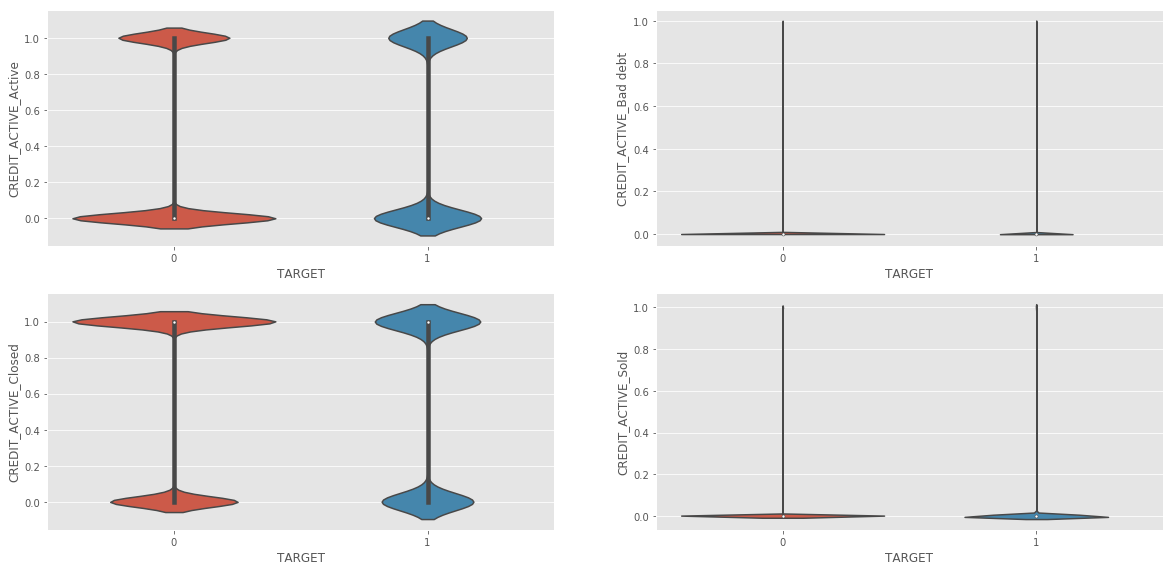

In [40]:
def violinplot(df, cols):
    """
    This will plot both violin and box plot on top of each othere for 
    each features, which would be better to understand the data,
    for the categories of the target variable.
    The dataframe has to contain 40 features to use this function.
    """
    
    plt.figure(figsize =(20,20))
    for idx, ft in enumerate(cols):
        plt.subplot(len(cols),2, idx+1)
        sns.violinplot(y=df[ft], x=df["TARGET"])
        #sns.boxplot(y=df[ft], x=df["TARGET"])

feature_list =credit_active.columns.tolist()[2:]
violinplot(credit_active, feature_list)


In [ ]:
sns.violinplot()

In [21]:
# Exploring the column the credit_active column and its relationship with the target column
bureau_credit_active = bureau_train.groupby("SK_ID_CURR")["CREDIT_ACTIVE"].count().reset_index()
#Extracting the target column as a dataframe
target = train[["SK_ID_CURR","TARGET"]]
# Adding the target colun to the bureau_credit_active
bureau_credit_active = pd.merge(bureau_credit_active,target, how ="left" , on = "SK_ID_CURR")
# Visualizing the corrlation between the number of accounts active under credit_active and target feature.
bureau_credit_active.head()

,SK_ID_CURR,CREDIT_ACTIVE,TARGET
0,100002,8,1
1,100003,4,0
2,100004,2,0
3,100006,0,0
4,100007,1,0


In [22]:
# Here I am grouping by the number of CREDIT_ACTIVE and aggregating target columns by count and sum.
# The count column tells us how many observations for a particular credit type
# getting dummies for the object column CREDIT_Active
credit_active = pd.get_dummies(bureau_train[["SK_ID_CURR","CREDIT_ACTIVE", "TARGET"]])
credit_active.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold']

In [23]:

def custom_sum(series):
       return reduce(lambda x, y: x, series)
# Now grouping by SK_ID_CURR
credit_active_sum = credit_active.groupby("SK_ID_CURR").agg({
    "TARGET":custom_sum,
    "CREDIT_ACTIVE_Active":"sum",
    "CREDIT_ACTIVE_Closed":"sum",
    "CREDIT_ACTIVE_Sold":"sum",
    "CREDIT_ACTIVE_Sold":"sum"})
credit_active_sum.head()

,TARGET,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold
SK_ID_CURR,,,,
100002,1,2,6,0
100003,0,1,3,0
100004,0,0,2,0
100006,0,0,0,0
100007,0,0,1,0


In [100]:
exercise = sns.load_dataset("exercise")
exercise.pulse.nunique()

39

In [52]:
bureau_train.columns

Index(['SK_ID_CURR', 'TARGET', 'SK_ID_BUREAU', 'CREDIT_ACTIVE',
       'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'],
      dtype='object')

In [24]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [25]:
credit_card_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3090496.0,3.840312e+06,3.090496e+06,3090496.0,3535076.0,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.827686e+04,1.538080e+05,5.962299e+03,7.432263e+03,2.881647e+02,2.968840e+03,3.541778e+03,...,5.595036e+04,5.808502e+04,5.809459e+04,NaN,7.031439e-01,4.810333e-03,NaN,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.074641e+05,1.651457e+05,2.803397e+04,3.336682e+04,8.197021e+03,2.066321e+04,5.525350e+03,...,1.015177e+05,1.071769e+05,1.071802e+05,0.0,3.190347e+00,8.239746e-02,0.0,0.0,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,4.0,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,15.0,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.0,0.000000e+00,0.000000e+00,0.0,32.0,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,51.0,1.650000e+02,1.200000e+01,165.0,120.0,3.260000e+03,3.260000e+03


In [44]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [45]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [46]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int32
SK_ID_CURR                    int32
MONTHS_BALANCE                int8
AMT_BALANCE                   float32
AMT_CREDIT_LIMIT_ACTUAL       int32
AMT_DRAWINGS_ATM_CURRENT      float32
AMT_DRAWINGS_CURRENT          float32
AMT_DRAWINGS_OTHER_CURRENT    float32
AMT_DRAWINGS_POS_CURRENT      float32
AMT_INST_MIN_REGULARITY       float32
AMT_PAYMENT_CURRENT           float32
AMT_PAYMENT_TOTAL_CURRENT     float32
AMT_RECEIVABLE_PRINCIPAL      float32
AMT_RECIVABLE                 float32
AMT_TOTAL_RECEIVABLE          float32
CNT_DRAWINGS_ATM_CURRENT      float16
CNT_DRAWINGS_CURRENT          int16
CNT_DRAWINGS_OTHER_CURRENT    float16
CNT_DRAWINGS_POS_CURRENT      float16
CNT_INSTALMENT_MATURE_CUM     float16
NAME_CONTRACT_STATUS          object
SK_DPD                        int16
SK_DPD_DEF                    int16
dtypes: float16(4), float32(1

In [47]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [49]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int32
SK_ID_CURR                int32
NUM_INSTALMENT_VERSION    float16
NUM_INSTALMENT_NUMBER     int16
DAYS_INSTALMENT           float16
DAYS_ENTRY_PAYMENT        float16
AMT_INSTALMENT            float32
AMT_PAYMENT               float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB


In [26]:
# Extracting the SK_ID_CURR and TARGET columns as a dataframe
train_id = train[["SK_ID_CURR","TARGET"]]
test_id = test[["SK_ID_CURR"]]

# Extracting only relevant observations from the bureau as well as adding the TARGET column to the bureau_train
installments_payments_train = pd.merge(train_id, installments_payments,how ="left", on ="SK_ID_CURR")
installments_payments_test  = pd.merge(test_id, installments_payments, how="left", on = "SK_ID_CURR")

shape_installements_train = installments_payments_train .groupby("SK_ID_CURR").sum().shape[0],
shape_installments_test = installments_payments_test.groupby("SK_ID_CURR").sum().shape[0],
                                 
#Checking if the bureau contains all of the train and test observations.
if train.shape[0] == shape_installements_train and shape_installments_test ==test.shape[0]:
    print("The total number of observations in the new_train and new_test matches with that for the train and the test.")


In [27]:
import featuretools as ft

In [43]:
def numberPossiblePasswords(numDigits, numPossiblePerDigit):
    numPasswords = numPossiblePerDigit**numDigits
    return numPasswords
    
def maxSecondsToCrack(numPossiblePasswords, secPerAttempt):
    time = numPossiblePasswords*secPerAttempt
    return time
nd = int(input("How many digits long is the passcode? "))        
nc = int(input("How many possible characters are there per digit? "))
secondsPerAttempt = .08
npp = numberPossiblePasswords(nd, nc)
totalSeconds = maxSecondsToCrack(npp, secondsPerAttempt)
print("It will take you " + str(totalSeconds) + " seconds maximum to crack the password.")



How many digits long is the passcode? 6
How many possible characters are there per digit? 10
It will take you 80000.0 seconds maximum to crack the password.


In [48]:
nd = int(input("How many digits long is the passcode? "))        
nc = int(input("How many possible characters are there per digit? "))
MinutesPerAttempt = .08/60
npp = numberPossiblePasswords(nd, nc)
totalSeconds = maxSecondsToCrack(npp, MinutesPerAttempt)
print("It will take you " + str(totalSeconds) + " minutes\s maximum to crack the password.")

How many digits long is the passcode? 6
How many possible characters are there per digit? 10
It will take you 1333.3333333333333 minutes\s maximum to crack the password.
